In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('C:/Users/kunji/Downloads/archive (2)/fraudTrain.csv',sep=',')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [4]:
data.isnull().values.any()

False

In [6]:
print(data.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


Text(0, 0.5, 'Frequency')

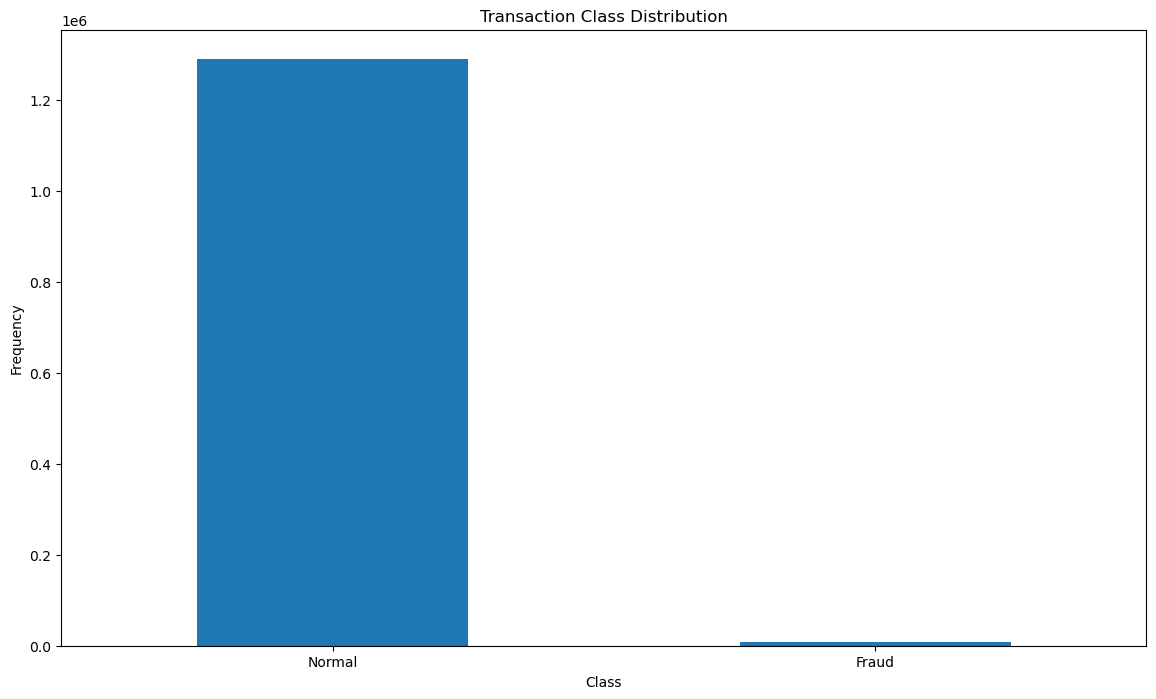

In [7]:
count_classes = pd.value_counts(data['is_fraud'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")


plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [9]:
print(data.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [12]:
## Get the Fraud and the normal dataset 
fraud = data[data['is_fraud'] == 1]
normal = data[data['is_fraud'] == 0]

In [13]:
print(fraud.shape,normal.shape)

(7506, 23) (1289169, 23)


In [19]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud_amt_stats = fraud['amt'].describe()
print(fraud_amt_stats)

count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: amt, dtype: float64


In [20]:
normal_amt_stats = normal['amt'].describe()
print(normal_amt_stats)

count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: amt, dtype: float64


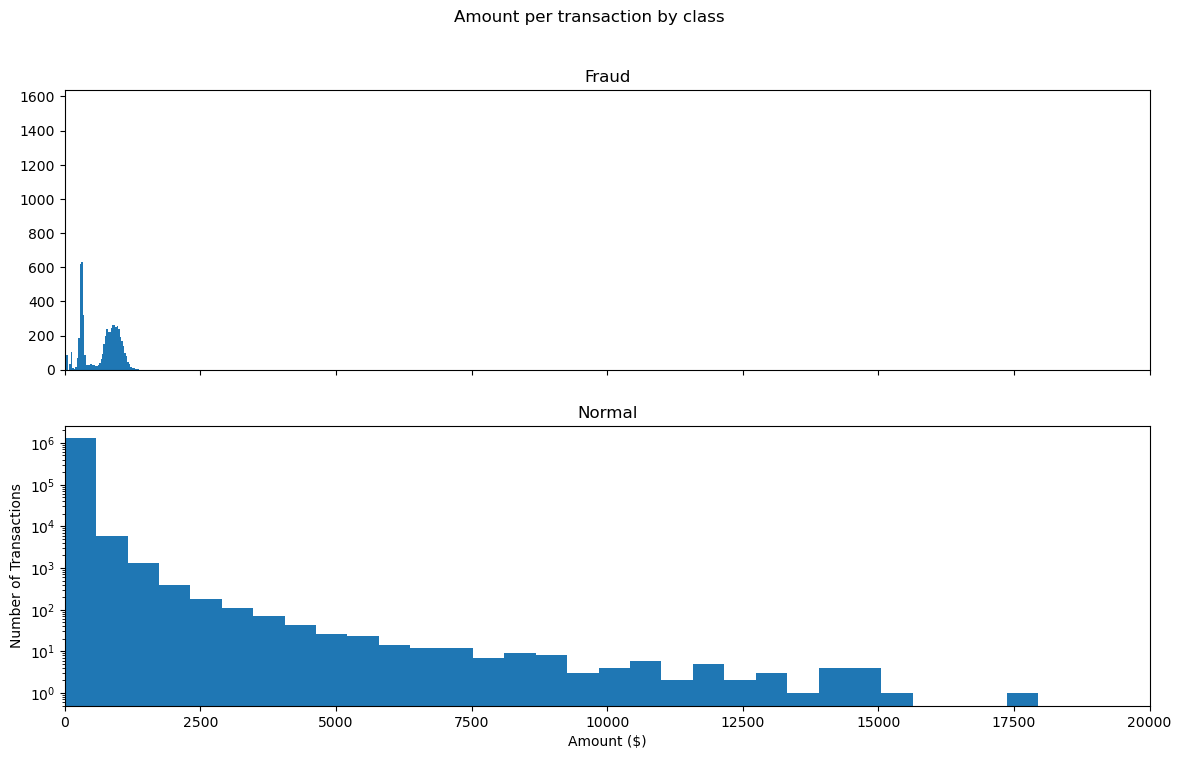

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud['amt'], bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal['amt'], bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

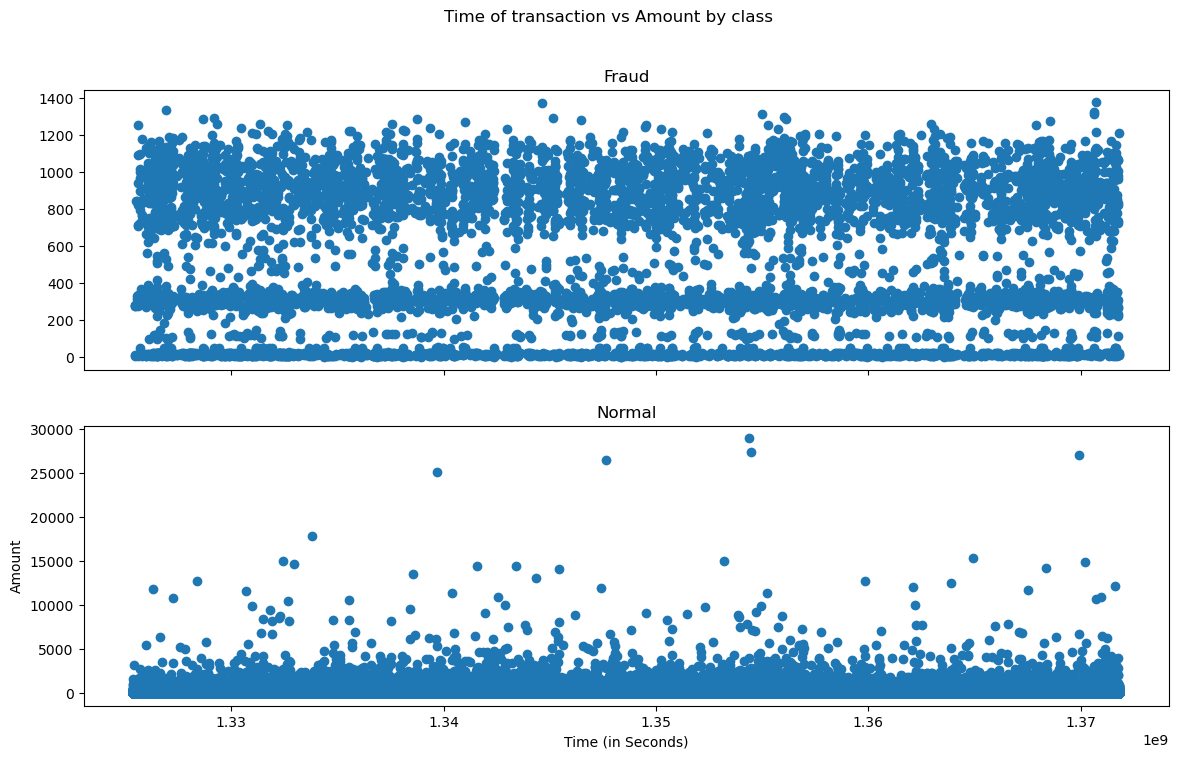

In [25]:
# Assuming the column name for time is 'unix_time'
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud['unix_time'], fraud['amt'])
ax1.set_title('Fraud')
ax2.scatter(normal['unix_time'], normal['amt'])
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [26]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(129668, 23)

In [27]:
data.shape

(1296675, 23)

In [30]:
#Determine the number of fraud and valid transactions in the dataset
Fraud = data1[data1['is_fraud'] == 1]
Valid = data1[data1['is_fraud'] == 0]
outlier_fraction = len(Fraud) / float(len(Valid))
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.005466684242767306
Fraud Cases : 705
Valid Cases : 128963


C:\Users\kunji\AppData\Local\Temp\ipykernel_23088\1038530286.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data1.corr()


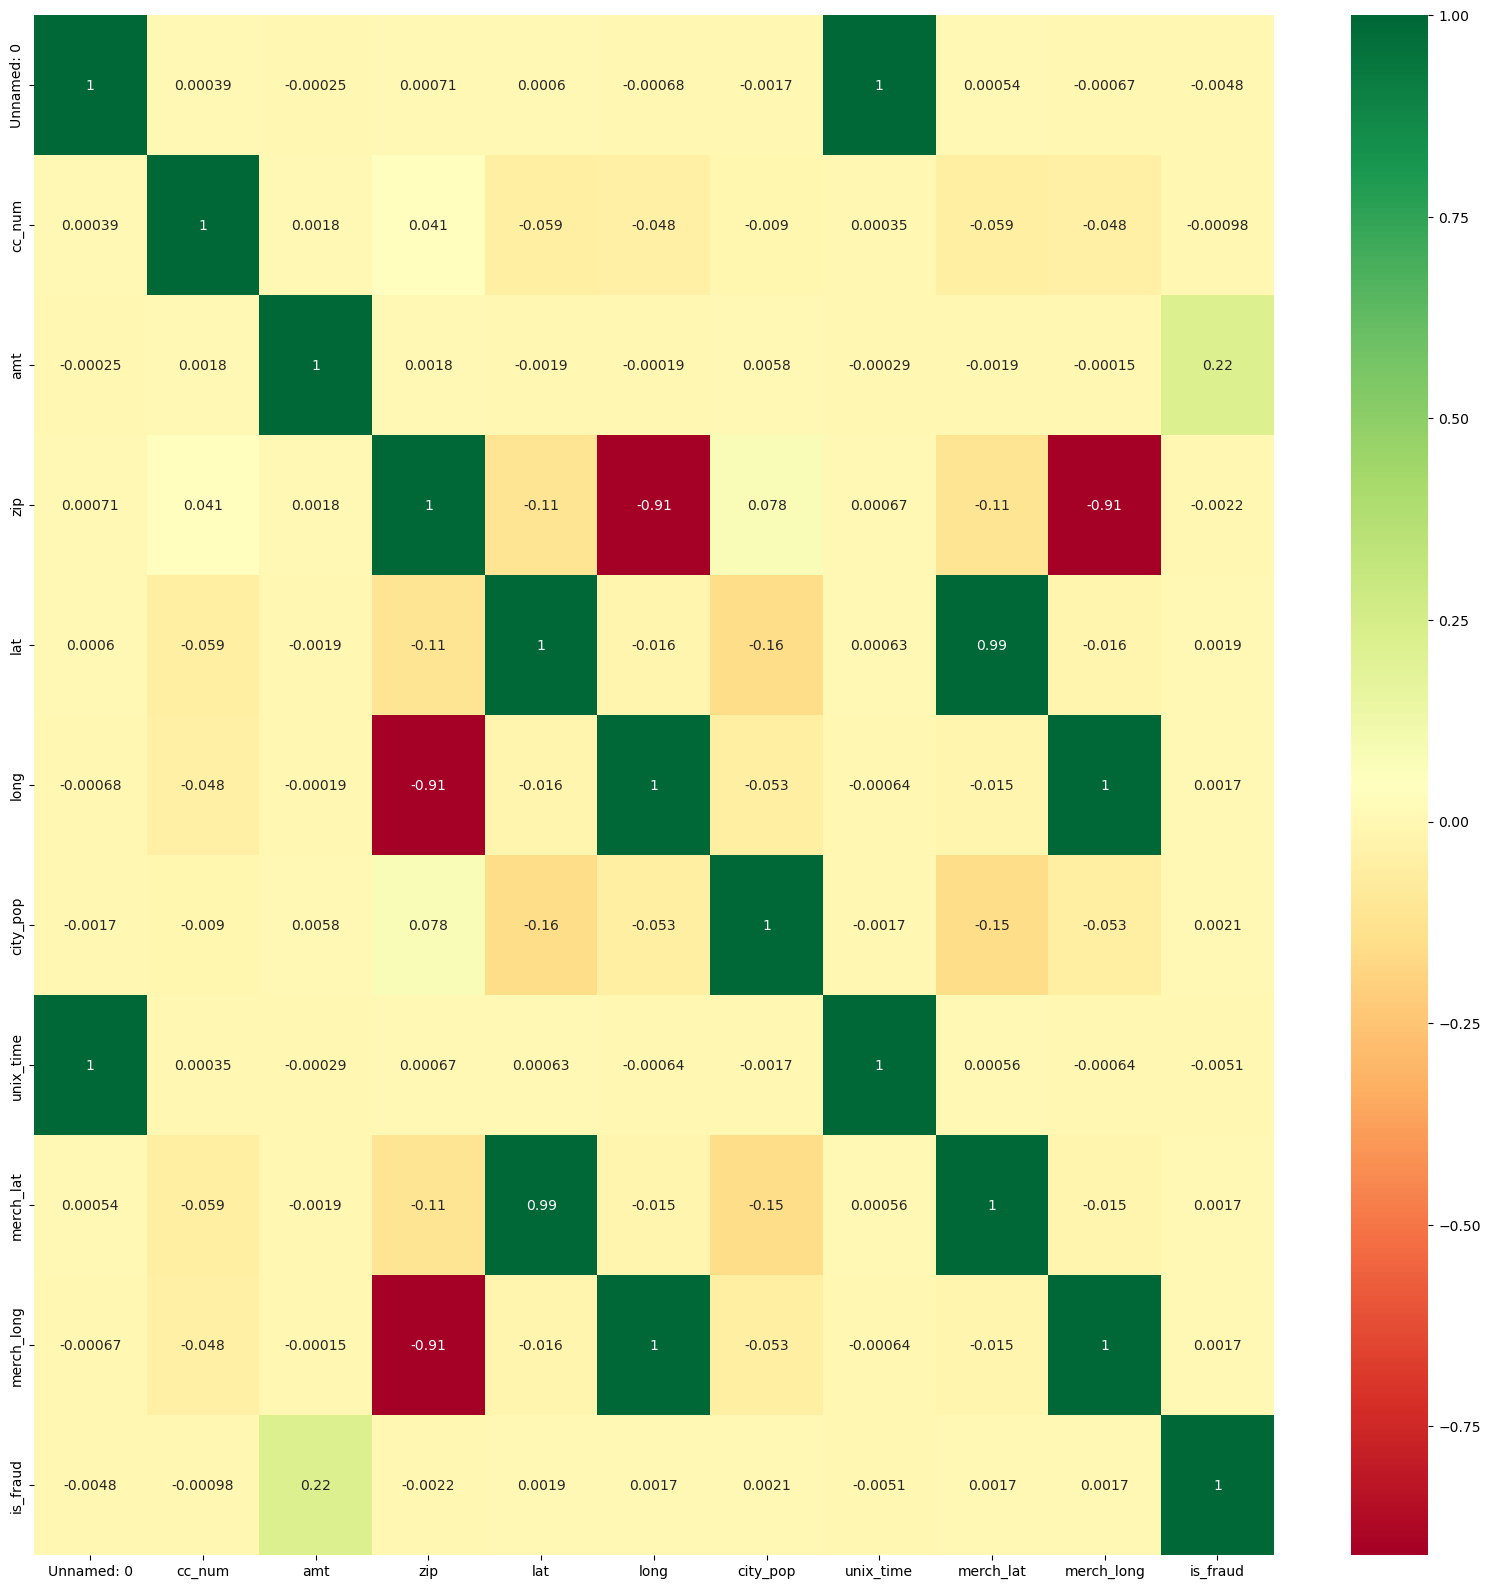

In [40]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [33]:
# Create independent and dependent features
columns = data1.columns.tolist()

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["is_fraud"]]

# Store the variable we are predicting 
target = "is_fraud"

# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

# Print the shapes of X & Y
print(X.shape)
print(Y.shape)


(129668, 22)
(129668,)


In [35]:
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples=len(X), 
                                        contamination=outlier_fraction, random_state=state, verbose=0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                               leaf_size=30, metric='minkowski',
                                               p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)
}

type(classifiers)


dict

In [43]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric features, including 'Time'
numeric_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
X_numeric = X[numeric_columns]

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

n_outliers = len(Fraud)

for clf_name, clf in classifiers.items():
    try:
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X_scaled)
            scores_prediction = clf.negative_outlier_factor_
        elif clf_name == "Support Vector Machine":
            clf.fit(X_scaled)
            y_pred = clf.predict(X_scaled)
        else:
            clf.fit(X_scaled)
            scores_prediction = clf.decision_function(X_scaled)
            y_pred = clf.predict(X_scaled)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1

        n_errors = (y_pred != Y).sum()

        print("{}: {}".format(clf_name, n_errors))
        print("Accuracy Score:")
        print(accuracy_score(Y, y_pred))
        print("Classification Report:")
        print(classification_report(Y, y_pred))
    except Exception as e:
        print(f"Error in {clf_name}: {e}")


Isolation Forest: 1364
Accuracy Score:
0.989480827960638
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    128963
           1       0.04      0.04      0.04       705

    accuracy                           0.99    129668
   macro avg       0.51      0.52      0.52    129668
weighted avg       0.99      0.99      0.99    129668

Local Outlier Factor: 1346
Accuracy Score:
0.9896196440139433
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    128963
           1       0.05      0.05      0.05       705

    accuracy                           0.99    129668
   macro avg       0.52      0.52      0.52    129668
weighted avg       0.99      0.99      0.99    129668

Support Vector Machine: 6495
Accuracy Score:
0.9499105407656476
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      